In [1]:
#This applies to outputs with SSH, SST (unfiltered), and (u,v) as inputs. 
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold
from copy import deepcopy
from scipy.stats import pearsonr
from pathlib import Path
import numpy.fft as fft
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
if 'D:/hw_pythonfuncs' not in sys.path:   
    sys.path.append('D:/hw_pythonfuncs' )
import hwm0 as m0
import hwffts as hwfft

vel_cmap  = 'BrBG' #'viridis'
vort_cmap = 'PRGn'
ssh_cmap  = 'bwr'
sst_cmap = 'inferno'

bottom_slice = slice(0,256)
mid_slice = slice(232, 488)
top_slice = slice(464, 720)
    
def corr(data, mod):
    return pearsonr(data.flatten(), mod.flatten())[0]
def L2_R(data,mod):
    return R2(data.flatten(), mod.flatten())
def performance_metrics(data, mod):
    return corr(data, mod), L2_R(data,mod)

modeloutput_dir = '../model_outputs/'
outputfiles = np.load(modeloutput_dir+'FilteredTcombs_UNet.npz')
inputfiles = np.load(modeloutput_dir+'inputT_filtered.npz')

snap_index = 100
colorlist=['#DDAA33','#004488','#BB5566']
figfolder = '../hwfigures/'
iplotend = 90

In [2]:
#T_raw_train = inputfiles['arr_0'] #Dimension: time - channel - height - width (150-2-720-256) 
T_raw_test = inputfiles['arr_1']
#T_du5_train = inputfiles['arr_2']
T_du5_test = inputfiles['arr_3']
#T_du25_train = inputfiles['arr_4'] 
T_du25_test = inputfiles['arr_5']

HT_du5_out_mod = outputfiles['arr_0'] #Dimension: time - channel - height - width (150-2-720-256) 
HT_du25_out_mod = outputfiles['arr_1']
UT_du5_out_mod = outputfiles['arr_2'] 
UT_du25_out_mod = outputfiles['arr_3']
HUT_du5_out_mod = outputfiles['arr_4']
HUT_du25_out_mod = outputfiles['arr_5']

#The truth of the test data is saved in another file (peoduced Configurations involving H, U, T)
npfile = np.load(modeloutput_dir+'HUTcombs_UNet.npz')
Truth_test = npfile['arr_7']
#Also loading the outputs with raw T as one of the input fields
HT_out_mod = npfile['arr_3']
UT_out_mod = npfile['arr_4']
HUT_out_mod = npfile['arr_6']

In [8]:
print(T_raw_test.shape)
print(T_du5_test.shape)
print(HUT_out_mod.shape)

(150, 1, 722, 258)
(150, 1, 722, 258)
(150, 2, 720, 256)


In [3]:
nt, _, ny, nx= np.shape(HT_du5_out_mod)

dx = 4000 #Grid resolution is 4 km
Lx = nx*dx
Ly = ny*dx
print (Ly)

#axes used for plotting only
x_axis = np.arange(0, Lx, dx)/1000 # in km
y_axis = np.arange(0, Ly, dx)/1000
extent = [np.min(x_axis), np.max(x_axis), np.min(y_axis), np.max(y_axis)]

2880000


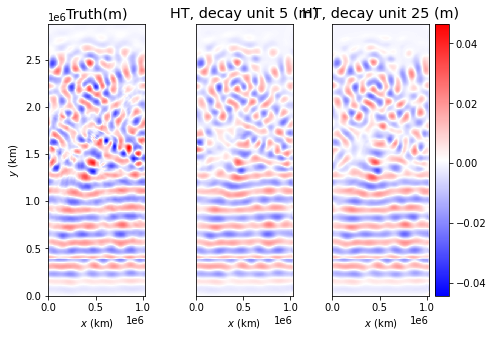

In [4]:
HT_du5_wave = HT_du5_out_mod[snap_index,0,:, : ]
HT_du25_wave = HT_du25_out_mod[snap_index,0,:, : ]
true_wave = Truth_test[snap_index,0,:, : ]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (7.5,5))

clims = (np.min(true_wave), np.max(true_wave))

im1 = ax1.pcolor(x_axis, y_axis, true_wave, cmap=ssh_cmap, clim =clims)
ax1.set_title(r'Truth(m)',fontsize ='x-large')
# fig.colorbar(im1, ax = ax1)

im2 = ax2.pcolor(x_axis, y_axis, HT_du5_wave, cmap=ssh_cmap, clim =clims)
ax2.set_title('HT, decay unit 5 (m)',fontsize ='x-large')
# fig.colorbar(im2, ax = ax2)

ax2.get_yaxis().set_visible(False)

im3 = ax3.pcolor(x_axis, y_axis, HT_du25_wave, cmap=ssh_cmap, clim =clims)
ax3.set_title(r'HT, decay unit 25 (m)',fontsize ='x-large')
fig.colorbar(im1, ax = ax3)
ax3.get_yaxis().set_visible(False)

# rect_orig = (78, 65)
# rect_size = 80
zoom_x1, zoom_x2 = 75, 160  # Example coordinates for zoomed-in section
zoom_y1, zoom_y2 = 325, 410

extent = [zoom_x1, zoom_x2, zoom_y1, zoom_y2]
zoom_width = "70%"

ax1.set_xlabel(r'$x$ (km)') 
ax1.set_ylabel(r'$y$ (km)') 
ax2.set_xlabel(r'$x$ (km)') 
ax3.set_xlabel(r'$x$ (km)') 

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

plt.show()

0.8214422612295984
0.7674898776087352
0.871668534762817
0.8660079035182356
0.9683376608613731
0.960986766024131


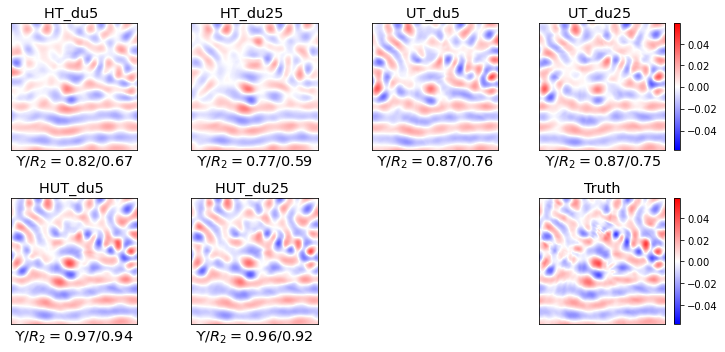

In [5]:
all_outputs = [HT_du5_out_mod, HT_du25_out_mod, UT_du5_out_mod, UT_du25_out_mod, HUT_du5_out_mod, HUT_du25_out_mod]
outputs_cosssh_HUTcomb =  np.stack([array[:, 0, :, :] for array in all_outputs], axis=0)
outputs_sinssh_HUTcomb =  np.stack([array[:, 1, :, :] for array in all_outputs], axis=0)

field_max = np.max(outputs_cosssh_HUTcomb)
field_min = np.min(outputs_cosssh_HUTcomb)
truth_snapshot = Truth_test[snap_index, 0]
model_ordering = ['HT_du5', 'HT_du25','UT_du5', 'UT_du25', 'HUT_du5', 'HUT_du25']
fig=plt.figure(figsize = (10.5,5))
norm = TwoSlopeNorm(vcenter =0)
for i in range(6):
    plt.subplot(2, 4,i+1)
    plt.imshow(outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :], origin ='lower', cmap = ssh_cmap, norm=norm)
#     plt.colorbar()
    plt.clim(field_min, field_max)
    correlation = corr(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
    coeff_determ = L2_R(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
    print (correlation)
#     plt.text(40, 20, r'$\mathcal{\Upsilon}$ = ' +  str(round(correlation, 2)), fontsize = 'x-large')
#     plt.text(40, 60, r'$R_2$ = ' +  str(round(coeff_determ, 2)), fontsize = 'x-large')
    plt.xlabel(r'$\mathcal{\Upsilon}/R_2 = $'+ str(round(correlation, 2))+'/'+str(round(coeff_determ, 2)),
               fontsize = 'x-large')
    plt.xticks([])
    plt.yticks([])
    if i==3:
        plt.colorbar()

    plt.title('{} '.format(model_ordering[i]), fontsize = 'x-large')
plt.subplot(2,4,8)
plt.imshow(truth_snapshot[mid_slice, :] , origin ='lower', cmap = ssh_cmap, norm =norm)
plt.colorbar()
plt.title('Truth',  fontsize = 'x-large')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
# plt.title('{} '.format(to_ssh_model_names[i]), fontsize = 'xx-large')
# fig.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

In [6]:
#Borrowing Jeff's azimuthal averaging code
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    HW: it seems to work only when the grid spcaing of x and y are the same.
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:   
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1]) #hw: this only makes sense if the grid spacing of x and y are the same. 

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius #hw: : Finds the indices where the differences are non-zero, which correspond to locations where the radius value changes, effectively capturing the unique integer radius values.
    nr = rind[1:] - rind[:-1]        # number of radius bin 
#     print ('nr', nr)
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
    return radial_prof

def hwazimuthalAveAxis(image, dx):
    """
    Output the axis on which the output of azimuthalAverage is evaluated on. 
    Assuming that the axis spacing in the horizontal and vertical directions are the same.
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)
    r = np.hypot(x, y) #hw: this only makes sense if the grid spacing of x and y are the same. 

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    #i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius #hw: : Finds the indices where the differences are non-zero, which correspond to locations where the radius value changes, effectively capturing the unique integer radius values.

    redges = r_sorted[rind]
    ibincenters = (redges[1:]+redges[:-1])/2#bin centers of the azimuthal averages
    irout = ibincenters 
    rout = irout * dx
    return rout

In [7]:
#power spectra using Gaussian window
def make_gaussian_window_xy(x, y, sigma_fraction=1/6):
    """
    Creates a 2D Gaussian window for use in FFT-based spectral analysis.
    
    Parameters:
        x (1D array): x-axis grid (real-space), centered at 0.
        y (1D array): y-axis grid (real-space), centered at 0.
        sigma_fraction (float): Fraction of domain length used for Gaussian width (default 1/6).
        
    Returns:
        2D array: Gaussian window of shape (len(x), len(y)).
    """
    # Ensure x and y are centered at zero
    if x[len(x)//2 - 1] != 0 or y[len(y)//2 - 1] != 0:
        raise ValueError("x and y must be centered at 0 for the Gaussian window to work correctly.")
    
    Lx = x[-1] - x[0] + (x[1] - x[0])
    Ly = y[-1] - y[0] + (y[1] - y[0])
    
    sigma_x = Lx * sigma_fraction
    sigma_y = Ly * sigma_fraction
    
    Y, X = np.meshgrid(y, x, indexing='ij')
    gaussian_window = np.exp(-((X**2) / (2 * sigma_x**2) + (Y**2) / (2 * sigma_y**2)))
    #gaussian_window = np.exp(-((Y**2) / (2 * sigma_y**2)))

    return gaussian_window

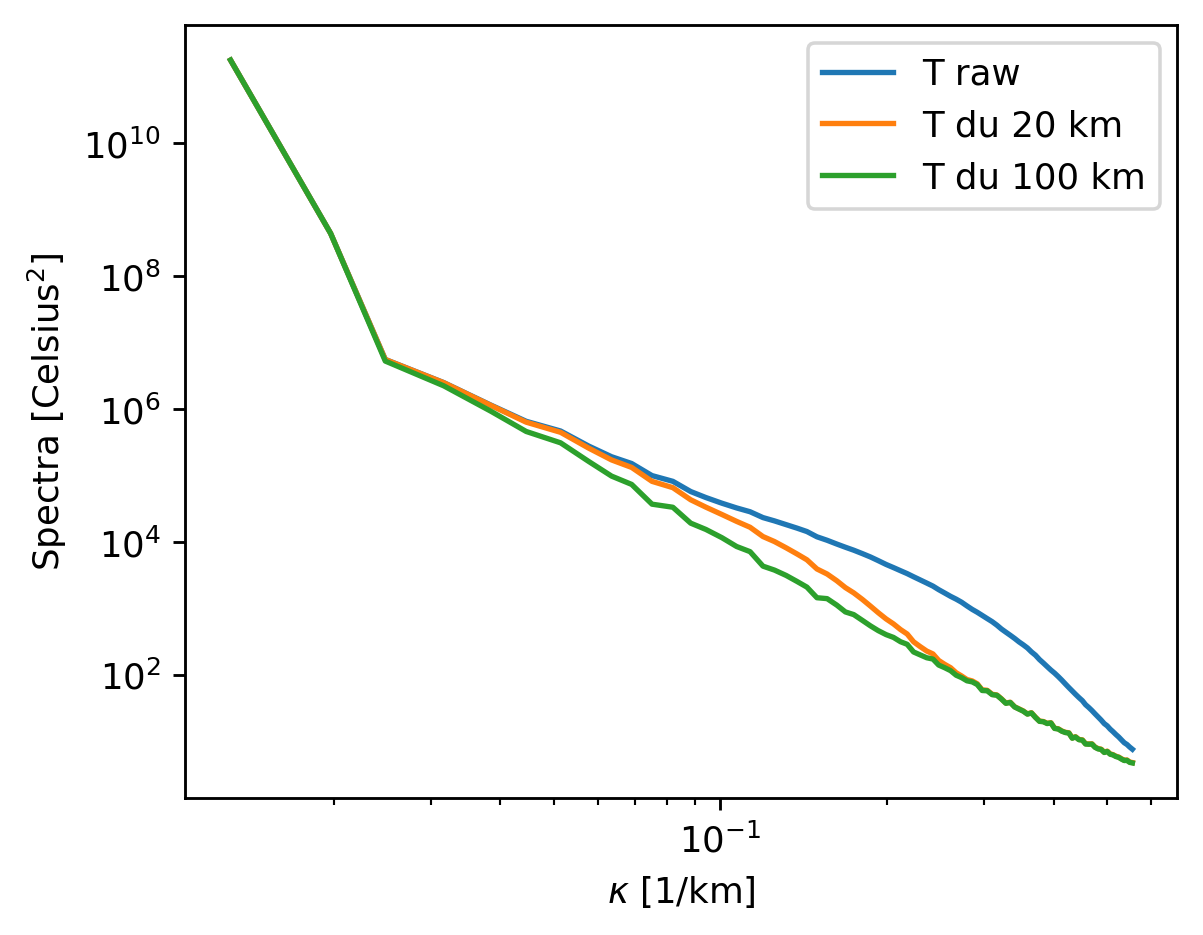

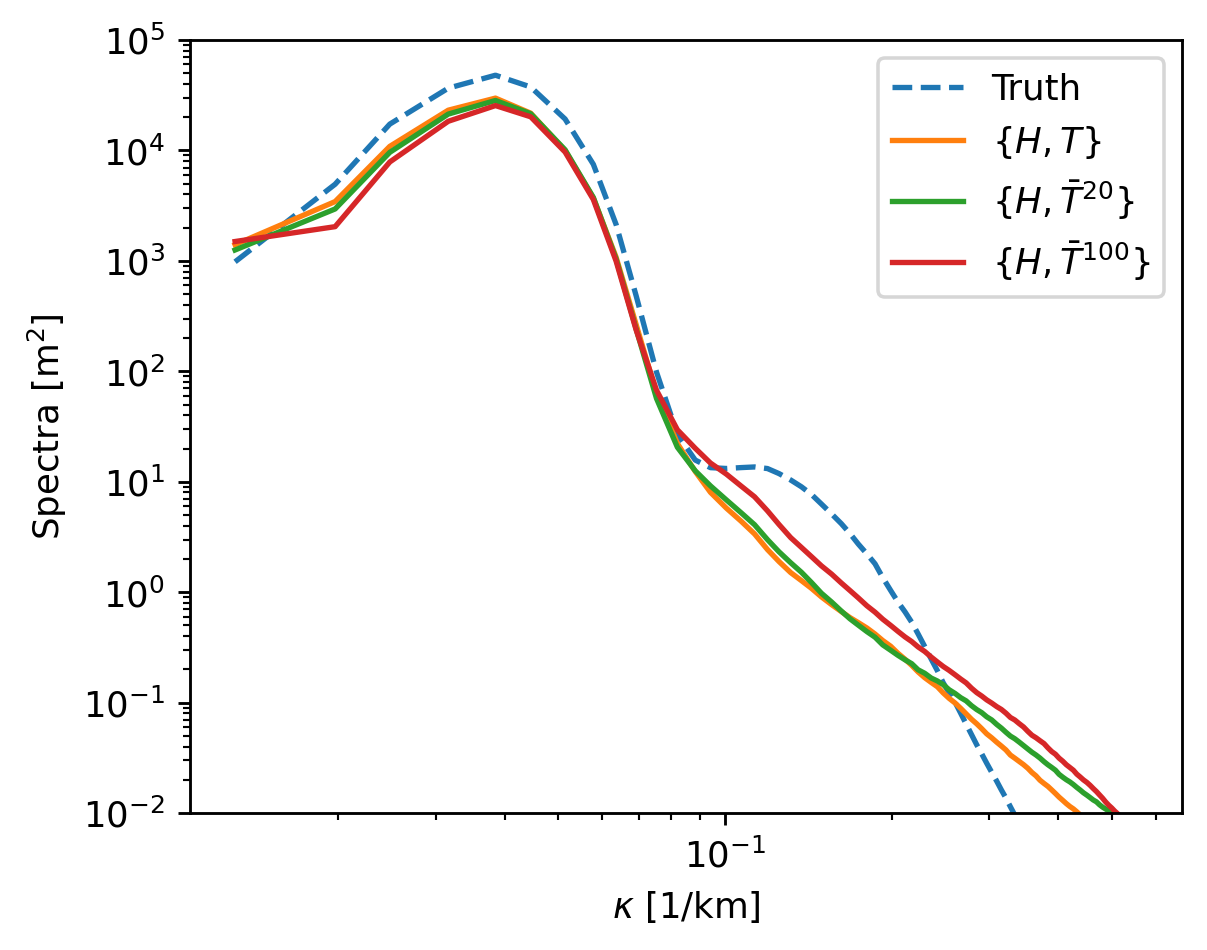

In [47]:
#input temperature and output SSH, for the down-jet panel
#number of grid points of wavenumbers k, l
#This version applies gaussian window in both x and y
#This is justified in that the periodic condition does not necessarily hold for the generated figures. 
nk = nx
nl = top_slice.stop - top_slice.start

#x and y axis in the real space, which are counterparts of wavenumbers k, l.
x = np.linspace(0,(nx-1)*dx,nk)
y = np.linspace(0,(nl-1)*dx,nl)
#Make them center at 0 (for hwffts to work)
x = x-x[nk//2-1]
y = y-y[nl//2-1]
Lx = nk*dx
Ly = nl*dx
#wavenumbers k,l
k=hwfft.k_of_x(x)
l=hwfft.k_of_x(y)

gaussian_window_xy = make_gaussian_window_xy(x, y)

#This funciton is not intended to be very customizable. It is here only to save space. 
def powerspectra1D (HUT_out_mod, idim = 0, slice = top_slice, window = gaussian_window_xy, itstart = -1-100, itend = -1):
    #Power spectra of output ssh_cos based on all the last 100 snapshots (change itstart and itend to adjust the snapshots).
    S_HUT=np.zeros((nk,nl)) #2D power spectra
    ncount = 0
    for it in np.arange(itstart,itend):
        ncount = ncount + 1
        ssh_HUT_windowed = HUT_out_mod[it,idim,slice,:] * window #idim =0 means looking at ssh_cos for the output files 
        ssh_HUT_kl=hwfft.hwfft2(x,y,ssh_HUT_windowed)
        S_HUT=S_HUT+np.real(ssh_HUT_kl*np.conjugate(ssh_HUT_kl))/(Lx*Ly)
    S_HUT=S_HUT/ncount
    #Now we compute the azimuthal averages of the 2D spectra; i.e., we compute the average of them, which are functions of (k,l), as functions of \sqrt{k^2+l^2}, averaged over narrow rings in \sqrt{k^2+l^2}
    S_HUT_m0=azimuthalAverage(S_HUT)
    return S_HUT_m0

S_Traw_m0 = powerspectra1D (T_raw_test[:,:,1:-1,1:-1])
S_T_du5_m0 = powerspectra1D (T_du5_test[:,:,1:-1,1:-1])
S_T_du25_m0 = powerspectra1D (T_du25_test[:,:,1:-1,1:-1])

S_HUTraw_m0 = powerspectra1D (HUT_out_mod)
S_HUTdu5_m0 = powerspectra1D (HUT_du5_out_mod)
S_HUTdu25_m0 = powerspectra1D (HUT_du25_out_mod)

S_HTraw_m0 = powerspectra1D (HT_out_mod)
S_HTdu5_m0 = powerspectra1D (HT_du5_out_mod)
S_HTdu25_m0 = powerspectra1D (HT_du25_out_mod)

S_truth_m0 = powerspectra1D (Truth_test)

# S_UTraw_m0 = powerspectra1D (UT_out_mod)
# S_UTdu5_m0 = powerspectra1D (UT_du5_out_mod)
# S_UTdu25_m0 = powerspectra1D (UT_du25_out_mod)


dk = k[1]-k[0]
kappa =  hwazimuthalAveAxis(np.zeros((nk,nl)), dk)

fig1,axs1=plt.subplots(figsize=(5,4))
fig1.set_dpi(256)
axs1.loglog(kappa[1:iplotend]*1000,(S_Traw_m0[1:iplotend]),label=r'T raw', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_T_du5_m0[1:iplotend]),label='T du 20 km', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_T_du25_m0[1:iplotend]),label='T du 100 km', linewidth=1.5)
axs1.legend()
#axs1.set_ylim([0.001, 2*10**5])
axs1.set_xlabel(r'$\kappa$ (1/km)')
axs1.set_ylabel(r'Spectra [Celsius$^2$]')
#fig1.savefig(figfolder+'spectrum_comparison_trunc_downjet.png', bbox_inches='tight',dpi = 256)

fig1,axs1=plt.subplots(figsize=(5,4))
fig1.set_dpi(256)
axs1.loglog(kappa[1:iplotend]*1000,(S_truth_m0[1:iplotend]),label=r'Truth', linestyle='--', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_HTraw_m0[1:iplotend]),label=r'$\{H,T\}$', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_HTdu5_m0[1:iplotend]),label=r'$\{H,\bar{T}^{20}\}$', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_HTdu25_m0[1:iplotend]),label=r'$\{H,\bar{T}^{100}\}$', linewidth=1.5)
axs1.legend()
axs1.set_ylim([0.01, 10**5])
axs1.set_xlabel(r'$\kappa$ (1/km)')
axs1.set_ylabel(r'Spectra (m$^2$)')
fig1.savefig(figfolder+'spectrum_comparison_Tfilt_downjet.png', bbox_inches='tight',dpi = 256)



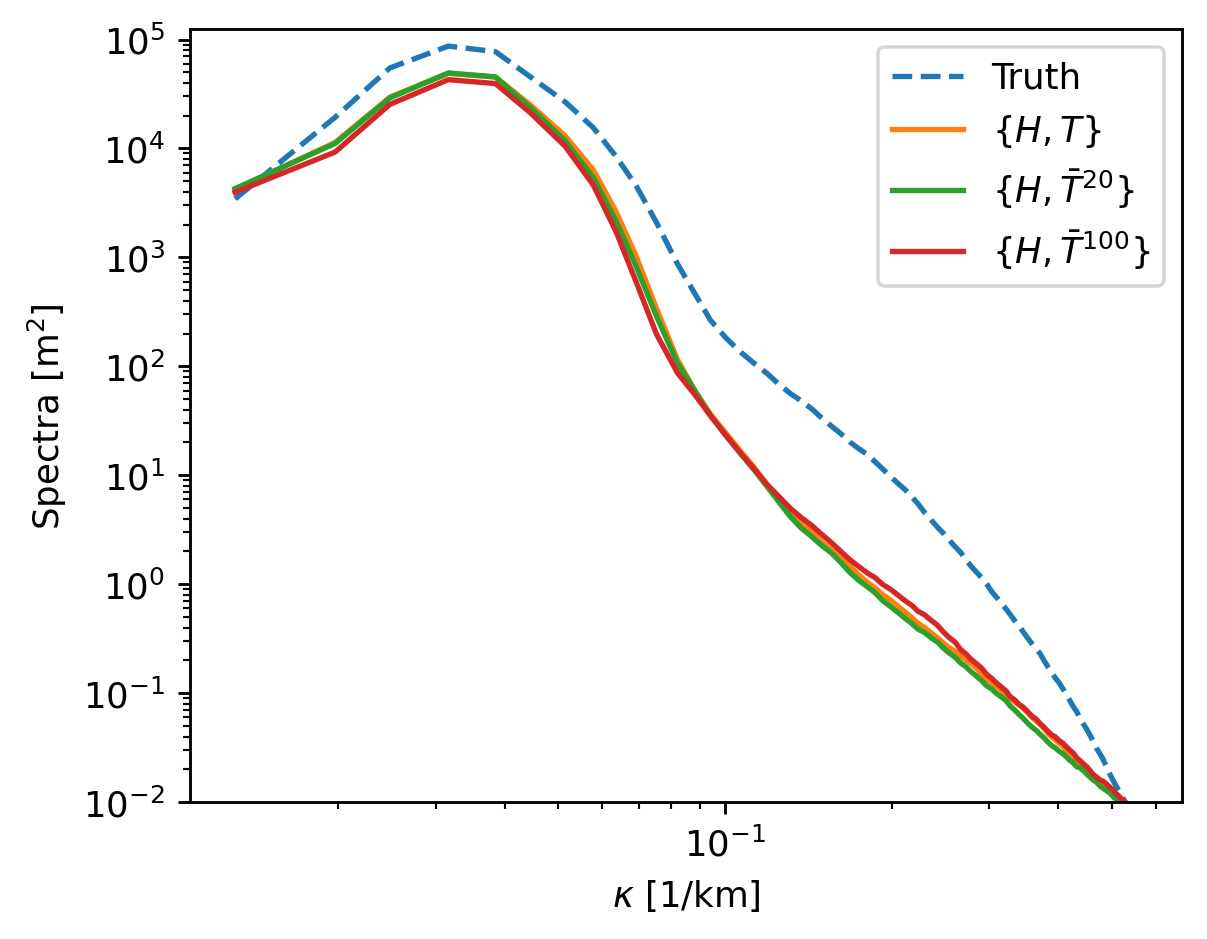

In [48]:
S_HUTraw_m0 = powerspectra1D (HUT_out_mod, slice = mid_slice)
S_HUTdu5_m0 = powerspectra1D (HUT_du5_out_mod, slice = mid_slice)
S_HUTdu25_m0 = powerspectra1D (HUT_du25_out_mod, slice = mid_slice)

S_HTraw_m0 = powerspectra1D (HT_out_mod, slice = mid_slice)
S_HTdu5_m0 = powerspectra1D (HT_du5_out_mod, slice = mid_slice)
S_HTdu25_m0 = powerspectra1D (HT_du25_out_mod, slice = mid_slice)

S_truth_m0 = powerspectra1D (Truth_test, slice = mid_slice)

dk = k[1]-k[0]
kappa =  hwazimuthalAveAxis(np.zeros((nk,nl)), dk)


fig1,axs1=plt.subplots(figsize=(5,4))
fig1.set_dpi(256)
axs1.loglog(kappa[1:iplotend]*1000,(S_truth_m0[1:iplotend]),label=r'Truth', linestyle='--', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_HTraw_m0[1:iplotend]),label=r'$\{H,T\}$', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_HTdu5_m0[1:iplotend]),label=r'$\{H,\bar{T}^{20}\}$', linewidth=1.5)
axs1.loglog(kappa[1:iplotend]*1000,(S_HTdu25_m0[1:iplotend]),label=r'$\{H,\bar{T}^{100}\}$', linewidth=1.5)
axs1.legend()
axs1.set_ylim([0.01, 10**6/8])
axs1.set_xlabel(r'$\kappa$ (1/km)')
axs1.set_ylabel(r'Spectra (m$^2$)')
fig1.savefig(figfolder+'spectrum_comparison_Tfilt_midjet.png', bbox_inches='tight',dpi = 256)


2880000


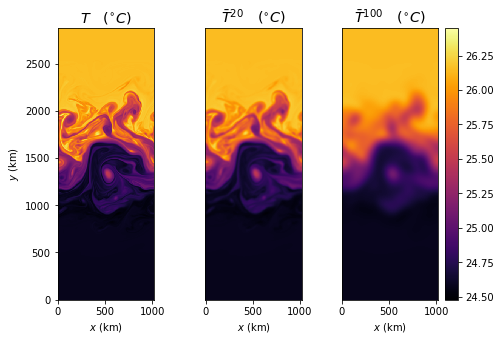

In [35]:
#Plot a snapshot of T before and after filtering
nt, _, ny, nx= np.shape(HT_du5_out_mod)

dx = 4000 #Grid resolution is 4 km
Lx = nx*dx
Ly = ny*dx
print (Ly)

#axes used for plotting only
x_axis = np.arange(0, Lx, dx)/1000 # in km
y_axis = np.arange(0, Ly, dx)/1000
extent = [np.min(x_axis), np.max(x_axis), np.min(y_axis), np.max(y_axis)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (7.5,5))

clims = (np.min(T_raw_test[snap_index,0,1:-1,1:-1]), np.max(T_raw_test[snap_index,0,1:-1,1:-1]))

im1 = ax1.pcolor(x_axis, y_axis, T_raw_test[snap_index,0,1:-1,1:-1], cmap=sst_cmap, clim =clims)
ax1.set_title(r'$T \quad (^{\circ}C)$',fontsize ='x-large')
# fig.colorbar(im1, ax = ax1)

im2 = ax2.pcolor(x_axis, y_axis, T_du5_test[snap_index,0,1:-1,1:-1], cmap=sst_cmap, clim =clims)
ax2.set_title(r'$\bar{T}^{20} \quad (^{\circ}C)$',fontsize ='x-large')
# fig.colorbar(im2, ax = ax2)

ax2.get_yaxis().set_visible(False)

im3 = ax3.pcolor(x_axis, y_axis, T_du25_test[snap_index,0,1:-1,1:-1], cmap=sst_cmap, clim =clims)
ax3.set_title(r'$\bar{T}^{100} \quad (^{\circ}C)$',fontsize ='x-large')
fig.colorbar(im1, ax = ax3)
ax3.get_yaxis().set_visible(False)

# rect_orig = (78, 65)
# rect_size = 80
zoom_x1, zoom_x2 = 75, 160  # Example coordinates for zoomed-in section
zoom_y1, zoom_y2 = 325, 410

extent = [zoom_x1, zoom_x2, zoom_y1, zoom_y2]
zoom_width = "70%"

ax1.set_xlabel(r'$x$ (km)') 
ax1.set_ylabel(r'$y$ (km)') 
ax2.set_xlabel(r'$x$ (km)') 
ax3.set_xlabel(r'$x$ (km)') 

ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

plt.show()

fig.savefig(figfolder+'T_filtered.png', bbox_inches='tight',dpi = 256)

